## Development tasks - comparison of task distance candidates

This notebook uses the experimental results of the development tasks and investigates which of the ~1000 candidates for task similarity estimation suits best - with respect to all transfer scenarios and meta metrics. It has to be considered that the "low" number of "independent" datapoints (28 development tasks) makes a robust estimation difficult (see also https://arxiv.org/pdf/2204.01403 and https://arxiv.org/pdf/2308.07444) - we thus aggregate across all 4 transfer scenarios and 5 meta metrics to achieve a more robust estimation.

In [1]:
import mml.interactive
from pathlib import Path
mml.interactive.init(Path('~/.config/mml.env').expanduser())
import pandas as pd
from mml_tf.aggregate import AggregateStrategy
from mml_tf.distances import LoadCachedDistances,get_variety
from mml_tf.evaluation import get_evaluations
from mml_tf.experiments import EXPERIMENTS, METRICS
from mml_tf.variants import variants

 _____ ______   _____ ______   ___
|\   _ \  _   \|\   _ \  _   \|\  \
\ \  \\\__\ \  \ \  \\\__\ \  \ \  \
 \ \  \\|__| \  \ \  \\|__| \  \ \  \
  \ \  \    \ \  \ \  \    \ \  \ \  \____
   \ \__\    \ \__\ \__\    \ \__\ \_______\
    \|__|     \|__|\|__|     \|__|\|_______|
         ____  _  _    __  _  _  ____  _  _
        (  _ \( \/ )  (  )( \/ )/ ___)( \/ )
         ) _ ( )  /    )( / \/ \\___ \ )  /
        (____/(__/    (__)\_)(_/(____/(__/
Interactive MML API initialized.


In [2]:
# load all task variants, pre-computed by notebook "0_fill_cache.ipynb" and stored within the "cache" folder
combined_variants = {name: LoadCachedDistances(name, zscore_axis=0) for name in variants}

### Step 1: Filter task distances

Exclude "degenerated" similarity measures that have too little variability in selecting source tasks. Such task distances likely do not generalize well (and we have some significant shift in imaging modalities from development to validation tasks).

<Axes: >

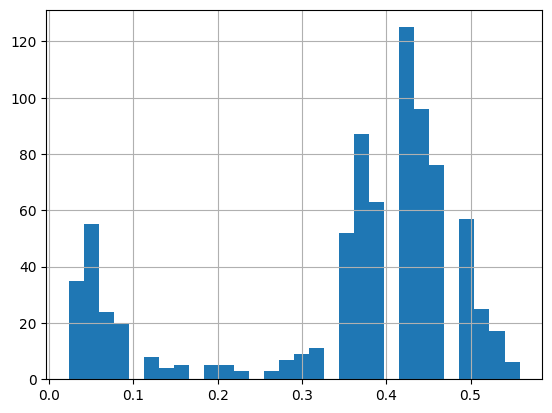

In [3]:
varieties = {dist: get_variety(distances=combined_variants[dist], shrunk=True) for dist in combined_variants}
pd.Series(varieties).hist(bins=30)

In [4]:
# the manual baseline serves as a rough estimation on what variety is expected
varieties['SEMANTIC']

0.37209302325581395

In [5]:
# we reduce the task distances to be inspected by a cutoff in variety, determined by the histogram plot and the manual baseline
print('Before filter:' + str(len(combined_variants)))
combined_variants = {name: dist_obj for name, dist_obj in combined_variants.items() if varieties[name] > 0.25}
print('After filter:' + str(len(combined_variants)))

Before filter:798
After filter:634


### Step 2: Evaluate task distances

We evaluate all remaining task distances on the development tasks using weightedtau, regret, improvement (=delta), percentile (=rank) & gain. For the latter 4 we average the top three suggestions. The three experiment runs of transfer measurement are aggregated beforehand with arithmetic mean to achieve better robustness. 

In [6]:
selected_evals = get_evaluations(all_distances=combined_variants.values(), aggregates=[AggregateStrategy.MEAN], metrics=METRICS, experiments=EXPERIMENTS, corr_meta_metrics=['weightedtau'], top_meta_metrics=['regret', 'rank', 'delta', 'gain'], top_mode='avg', top_k=3, validation=False)

Calculating...: 100%|██████████| 116656/116656 [09:50<00:00, 197.60it/s]


### Step 3: Aggregate evaluations along target tasks

As a first step we aggregate the evaluation results over the target tasks (leaving transfer scenario and meta metrics non-aggregated).

In [7]:
# absolut meta metric table
def get_absolute_meta_values(full_evaluations: pd.DataFrame, meta_metric: str, reverse_regret: bool = False) -> pd.DataFrame:
    meta_values_df = pd.DataFrame()
    for exp in EXPERIMENTS:
        sub_df = full_evaluations[(full_evaluations['exp'] == exp) & (full_evaluations['meta metric'] == meta_metric)]
        for group_name, group_df in sub_df.groupby('distances'):
            if meta_metric == 'regret' and reverse_regret:
                val_series = 1 - group_df['score']
            else:
                val_series = group_df['score']
            meta_values_df.at[group_name, exp + '-mean'] = val_series.mean()
            meta_values_df.at[group_name, exp + '-std'] = val_series.std()
    meta_values_df['mean'] = meta_values_df[[exp + '-mean' for exp in EXPERIMENTS]].mean(axis=1)
    return meta_values_df.sort_values(by='mean', ascending=False)

In [8]:
# note that regret is a meta metric that follows "the lower, the better" - in contrast to all other ones used, we thus compute an "aligned" version for later aggregation
aligned_regret_df = get_absolute_meta_values(full_evaluations=selected_evals, meta_metric='regret', reverse_regret=False)
aligned_regret_df

,Model<br>Architecture-mean,Model<br>Architecture-std,Pretraining<br>Data-mean,Pretraining<br>Data-std,Augmentation<br>Policy-mean,Augmentation<br>Policy-std,Co-Training<br>Data-mean,Co-Training<br>Data-std,mean
KLD-PP:NS-1000-BINS,0.741132,0.238555,0.727010,0.174439,0.752058,0.226828,0.769852,0.147894,0.747513
KLD-PP:NS-W:TS-100-BINS,0.744752,0.232733,0.717866,0.183223,0.751331,0.225970,0.770204,0.150314,0.746038
KLD-PP:NS-W:TS-1000-BINS,0.741837,0.236629,0.722624,0.183091,0.749938,0.226393,0.768327,0.149299,0.745682
KLD-PP:NS-100-BINS,0.740374,0.237741,0.716195,0.186933,0.750012,0.226683,0.768416,0.150206,0.743749
KLD-PP:NS-W:SW-1000-BINS,0.747997,0.196438,0.730924,0.191752,0.724337,0.226451,0.763998,0.165232,0.741814
...,...,...,...,...,...,...,...,...,...
KLD-PP:UU-A:0.001-W:SS,0.704011,0.250442,0.729280,0.164663,0.691934,0.226198,0.752491,0.188688,0.719429
LOG-S:0-T:1,0.700402,0.263612,0.736266,0.156883,0.700341,0.213464,0.737641,0.196001,0.718663
KLD-PP:UU-A:0.001,0.700402,0.263612,0.736266,0.156883,0.700341,0.213464,0.737641,0.196001,0.718663
KLD-PP:UU-A:0.1,0.700402,0.263612,0.736266,0.156883,0.700341,0.213464,0.737641,0.196001,0.718663


In [9]:
rank_df = get_absolute_meta_values(full_evaluations=selected_evals, meta_metric='rank')
rank_df

,Model<br>Architecture-mean,Model<br>Architecture-std,Pretraining<br>Data-mean,Pretraining<br>Data-std,Augmentation<br>Policy-mean,Augmentation<br>Policy-std,Co-Training<br>Data-mean,Co-Training<br>Data-std,mean
KLD-PP:NS-W:TS-100-BINS,0.550188,0.140238,0.607273,0.160864,0.606307,0.165877,0.543935,0.163180,0.576926
KLD-PP:NS-1000-BINS,0.538111,0.150988,0.626060,0.169965,0.608454,0.164460,0.531857,0.167080,0.576121
KLD-PP:NS-W:TS-1000-BINS,0.543210,0.144123,0.621766,0.154683,0.603892,0.163338,0.528368,0.163260,0.574309
KLD-PP:NS-100-BINS,0.536232,0.146261,0.604858,0.156191,0.596779,0.160208,0.533468,0.157181,0.567834
KLD-C-I-PP:NS-100-BINS,0.516110,0.156364,0.589063,0.168159,0.596444,0.155973,0.546444,0.149589,0.562015
...,...,...,...,...,...,...,...,...,...
KLD-PP:UU-A:0.01-W:SS,0.480475,0.149844,0.620370,0.133416,0.458816,0.127727,0.516761,0.150065,0.519106
KLD-PP:UU-A:0.1,0.472960,0.174104,0.626141,0.147957,0.469149,0.129032,0.500255,0.158105,0.517126
KLD-PP:UU-A:0.01,0.472960,0.174104,0.626141,0.147957,0.469149,0.129032,0.500255,0.158105,0.517126
LOG-S:0-T:1,0.472960,0.174104,0.626141,0.147957,0.469149,0.129032,0.500255,0.158105,0.517126


In [10]:
weightedtau_df = get_absolute_meta_values(full_evaluations=selected_evals, meta_metric='weightedtau')
weightedtau_df

,Model<br>Architecture-mean,Model<br>Architecture-std,Pretraining<br>Data-mean,Pretraining<br>Data-std,Augmentation<br>Policy-mean,Augmentation<br>Policy-std,Co-Training<br>Data-mean,Co-Training<br>Data-std,mean
KLD-C-I-PP:NS-100-BINS,0.028874,0.222544,0.141724,0.238061,0.187340,0.216694,-0.000079,0.162254,0.089465
KLD-PP:NS-100-BINS,0.032270,0.201256,0.080754,0.238384,0.190867,0.209308,-0.002999,0.180993,0.075223
KLD-C-I-PP:NS-W:TS-100-BINS,-0.003667,0.231472,0.160715,0.229874,0.157743,0.220929,-0.025014,0.152575,0.072444
KLD-PP:NS-W:TS-100-BINS,0.020980,0.210719,0.092076,0.233045,0.178862,0.212012,-0.009524,0.181079,0.070599
KLD-PP:NS-W:TS-1000-BINS,0.050453,0.213232,0.050612,0.236767,0.152077,0.205242,0.000411,0.197203,0.063388
...,...,...,...,...,...,...,...,...,...
KLD-PP:UU-A:0.001,-0.080730,0.181819,0.154570,0.177578,-0.121165,0.160384,-0.043823,0.204484,-0.022787
LOG-S:0-T:1,-0.080730,0.181819,0.154570,0.177578,-0.121165,0.160384,-0.043823,0.204484,-0.022787
KLD-PP:UU-A:0.001-W:SS,-0.088214,0.175220,0.145073,0.198583,-0.140742,0.169535,-0.027087,0.214356,-0.027743
KLD-PP:UU-A:0.1-W:SS,-0.088018,0.175259,0.144595,0.198597,-0.140827,0.169555,-0.026851,0.214273,-0.027775


In [11]:
gain_df = get_absolute_meta_values(full_evaluations=selected_evals, meta_metric='gain')
gain_df

,Model<br>Architecture-mean,Model<br>Architecture-std,Pretraining<br>Data-mean,Pretraining<br>Data-std,Augmentation<br>Policy-mean,Augmentation<br>Policy-std,Co-Training<br>Data-mean,Co-Training<br>Data-std,mean
KLD-PP:NS-W:SW-1000-BINS,0.797101,0.276470,0.376812,0.326664,0.855072,0.311525,0.775362,0.314696,0.701087
KLD-PP:NS-W:SN-1000-BINS,0.797101,0.276470,0.376812,0.326664,0.855072,0.311525,0.775362,0.314696,0.701087
KLD-PP:NS-W:BN-1000-BINS,0.797101,0.276470,0.376812,0.326664,0.847826,0.311955,0.775362,0.314696,0.699275
KLD-I-PP:NN-W:BS,0.753623,0.317667,0.413043,0.379635,0.826087,0.320024,0.775362,0.281568,0.692029
KLD-I-PP:NN-W:TS,0.753623,0.317667,0.413043,0.379635,0.826087,0.320024,0.775362,0.281568,0.692029
...,...,...,...,...,...,...,...,...,...
KLD-PP:UU-A:0.001-W:BS-100-BINS,0.724638,0.346441,0.355072,0.332608,0.833333,0.320108,0.702899,0.331314,0.653986
KLD-C-PP:NN-W:BS-100-BINS,0.724638,0.346441,0.355072,0.332608,0.833333,0.320108,0.702899,0.331314,0.653986
L-1-NORM-W:SN,0.724638,0.346441,0.347826,0.329283,0.818841,0.342154,0.717391,0.336778,0.652174
L-2-NORM-W:SS,0.702899,0.352965,0.340580,0.340581,0.804348,0.355389,0.746377,0.323444,0.648551


In [12]:
delta_df = get_absolute_meta_values(full_evaluations=selected_evals, meta_metric='delta')
delta_df

,Model<br>Architecture-mean,Model<br>Architecture-std,Pretraining<br>Data-mean,Pretraining<br>Data-std,Augmentation<br>Policy-mean,Augmentation<br>Policy-std,Co-Training<br>Data-mean,Co-Training<br>Data-std,mean
VDNA-PP:SS-1000-BINS,0.026068,0.043874,-0.008059,0.048318,0.030462,0.050356,0.025970,0.053577,0.018610
VDNA-PP:NN-1000-BINS,0.025948,0.043711,-0.008277,0.048258,0.030210,0.049828,0.026395,0.053403,0.018569
VDNA-PP:SS-100-BINS,0.026147,0.043573,-0.009074,0.044965,0.030955,0.051028,0.025749,0.052814,0.018444
L-1-NORM,0.025829,0.043699,-0.009112,0.048280,0.030960,0.049972,0.026068,0.053247,0.018436
VDNA-PP:SS-5-BINS,0.025830,0.043729,-0.008716,0.048272,0.030710,0.050160,0.025718,0.053618,0.018386
...,...,...,...,...,...,...,...,...,...
KLD-PP:UU-A:0.1-W:SS,0.010309,0.058155,-0.016744,0.046339,0.028966,0.048975,0.027378,0.052452,0.012477
KLD-PP:UU-A:0.001,0.008824,0.065040,-0.014417,0.051213,0.029007,0.048170,0.024016,0.046962,0.011857
KLD-PP:UU-A:0.1,0.008824,0.065040,-0.014417,0.051213,0.029007,0.048170,0.024016,0.046962,0.011857
KLD-PP:UU-A:0.01,0.008824,0.065040,-0.014417,0.051213,0.029007,0.048170,0.024016,0.046962,0.011857


### Step 4: Relativize evaluations within scenario and meta metric

Before aggregation along the remaining axes is possible we need to ensure to make values comparable as different metrics may exhibit different value ranges and different scenarios might inherently have different complexity. We thus relativize the combination of meta metric and scenario in comparison within all (remaining) task distances.

In [13]:
def get_relative_performance_by_experiment(exp: str) -> pd.DataFrame:
    col = exp + '-mean'  # column in the meta metrics dataframes
    s_list = []
    for df, name in zip([aligned_regret_df, delta_df, weightedtau_df, gain_df, rank_df], ['regret', 'delta', 'tau', 'gain', 'rank']):
        s = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
        s.name = name
        s_list.append(s)
    s_list.append(pd.Series(varieties, name='variety'))
    all_rankings = pd.DataFrame(s_list).T
    # we show three considerations we had during development
    # option 1: include all 5 meta metrics
    all_rankings['sum'] = all_rankings[['regret', 'delta', 'tau', 'gain', 'rank']].sum(axis=1)
    # option 2: ignore gain as it is rather imprecise and a simplified version of delta
    all_rankings['sumWOgain'] = all_rankings[['regret', 'delta', 'tau', 'rank']].sum(axis=1)
    # option 3: only focus on percentile and weightedtau, as they provide a fuller picture of relative performance
    all_rankings['tau+rank'] = all_rankings[['tau', 'rank']].mean(axis=1)
    return all_rankings

In [14]:
exp_1 = get_relative_performance_by_experiment(EXPERIMENTS[0])
# we show the relative performance of our final candidates
exp_1.loc[['KLD-PP:NS-W:SN-1000-BINS', 'KLD-PP:NS-W:TS-100-BINS', 'KLD-PP:NS-1000-BINS']]  

,regret,delta,tau,gain,rank,variety,sum,sumWOgain,tau+rank
KLD-PP:NS-W:SN-1000-BINS,0.994366,0.785743,0.691121,1.000000,0.797307,0.302326,4.268538,3.268538,0.744214
KLD-PP:NS-W:TS-100-BINS,0.926564,0.793008,0.752070,0.692308,0.798973,0.348837,3.962923,3.270615,0.775522
KLD-PP:NS-1000-BINS,0.850928,0.755679,1.000000,0.461538,0.674025,0.302326,3.742170,3.280631,0.837012


In [15]:
exp_2 = get_relative_performance_by_experiment(EXPERIMENTS[1])
# we show the relative performance of our final candidates
exp_2.loc[['KLD-PP:NS-W:SN-1000-BINS', 'KLD-PP:NS-W:TS-100-BINS', 'KLD-PP:NS-1000-BINS']]

,regret,delta,tau,gain,rank,variety,sum,sumWOgain,tau+rank
KLD-PP:NS-W:SN-1000-BINS,0.508012,0.579047,0.862980,0.73913,0.622960,0.302326,3.312129,2.572998,0.742970
KLD-PP:NS-W:TS-100-BINS,0.300274,0.384274,0.246326,0.26087,0.390260,0.348837,1.582003,1.321134,0.318293
KLD-PP:NS-1000-BINS,0.445738,0.459035,0.000000,0.26087,0.579118,0.302326,1.744761,1.483891,0.289559


In [16]:
exp_3 = get_relative_performance_by_experiment(EXPERIMENTS[2])
# we show the relative performance of our final candidates
exp_3.loc[['KLD-PP:NS-W:SN-1000-BINS', 'KLD-PP:NS-W:TS-100-BINS', 'KLD-PP:NS-1000-BINS']]

,regret,delta,tau,gain,rank,variety,sum,sumWOgain,tau+rank
KLD-PP:NS-W:SN-1000-BINS,0.538932,0.442909,0.445616,0.923077,0.438346,0.302326,2.788880,1.865803,0.441981
KLD-PP:NS-W:TS-100-BINS,0.987901,0.969798,0.963806,0.769231,0.985652,0.348837,4.676387,3.907156,0.974729
KLD-PP:NS-1000-BINS,1.000000,0.930108,0.897728,0.769231,1.000000,0.302326,4.597066,3.827835,0.948864


In [17]:
exp_4 = get_relative_performance_by_experiment(EXPERIMENTS[3])
# we show the relative performance of our final candidates
exp_4.loc[['KLD-PP:NS-W:SN-1000-BINS', 'KLD-PP:NS-W:TS-100-BINS', 'KLD-PP:NS-1000-BINS']]

,regret,delta,tau,gain,rank,variety,sum,sumWOgain,tau+rank
KLD-PP:NS-W:SN-1000-BINS,0.773832,0.916155,0.624108,0.714286,0.826446,0.302326,3.854827,3.140542,0.725277
KLD-PP:NS-W:TS-100-BINS,0.904936,1.000000,0.700425,0.928571,0.851917,0.348837,4.385849,3.457278,0.776171
KLD-PP:NS-1000-BINS,0.897495,0.953451,0.822107,0.857143,0.729982,0.302326,4.260177,3.403035,0.776045


### Step 5: Aggregate relativized evaluations

To conclude the final ranking we aggregate over the 4 transfer scenarios. We provide results for all three options we considered (see inline comments above).

In [18]:
def aggreate_relative_performances(option: str = 'sum') -> pd.DataFrame:
    s_list = []
    for df, name in zip([exp_1, exp_2, exp_3, exp_4], EXPERIMENTS):
        s = df[option]
        s.name = name
        s_list.append(s)
    all_rankings = pd.DataFrame(s_list).T
    all_rankings['sum'] = all_rankings.sum(axis=1)
    return all_rankings.sort_values(by='sum', ascending=False)

In [19]:
aggreate_relative_performances('sum').head()

,Model<br>Architecture,Pretraining<br>Data,Augmentation<br>Policy,Co-Training<br>Data,sum
KLD-PP:NS-W:TS-100-BINS,3.962923,1.582003,4.676387,4.385849,14.607162
KLD-PP:NS-1000-BINS,3.742170,1.744761,4.597066,4.260177,14.344174
KLD-PP:NS-W:SW-1000-BINS,4.268538,3.312129,2.788880,3.854827,14.224373
KLD-PP:NS-W:SN-1000-BINS,4.268538,3.312129,2.788880,3.854827,14.224373
KLD-PP:NS-W:TS-1000-BINS,3.920543,1.730052,4.350609,4.135292,14.136496


Among the top 5 candidates for this option there is "KLD-PP:NS-W:TS-100-BINS" which is the 100 bins and target weighted variant from the paper, as well as "KLD-PP:NS-1000-BINS" which is the unweighted 1000 bins variant and "KLD-PP:NS-W:SN-1000-BINS" which is the 1000 bins source weighted variant. Note that "KLD-PP:NS-W:SW-1000-BINS" performs exactly as "KLD-PP:NS-W:SN-1000-BINS" and is a variant that simply omits the normalization step of weights - hence can be ignored. Lastly "KLD-PP:NS-W:TS-1000-BINS" would comprise a 1000 bin target weighted variant, which we did not present in the paper. As can be seen below, these combinations show some substantial lead over the majority of other task distances inspected.

<Axes: >

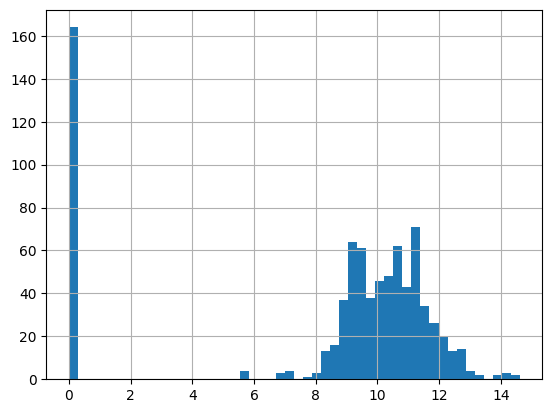

In [20]:
aggreate_relative_performances('sum')['sum'].hist(bins=50)

In [21]:
aggreate_relative_performances('sumWOgain').head()

,Model<br>Architecture,Pretraining<br>Data,Augmentation<br>Policy,Co-Training<br>Data,sum
KLD-PP:NS-1000-BINS,3.280631,1.483891,3.827835,3.403035,11.995392
KLD-PP:NS-W:TS-100-BINS,3.270615,1.321134,3.907156,3.457278,11.956183
KLD-PP:NS-W:TS-1000-BINS,3.305158,1.425704,3.735225,3.278149,11.744237
KLD-PP:NS-100-BINS,3.072840,1.205615,3.835015,3.307538,11.421008
KLD-C-I-PP:NS-100-BINS,2.506964,1.132432,3.837096,3.387079,10.863572


For this option the outstanding top 4 candidates are the 100 bins and 1000 bins variants of the target weighted and the unweighted variant of bKLD.

<Axes: >

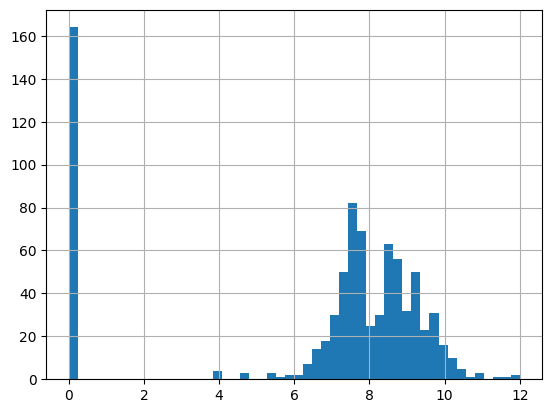

In [22]:
aggreate_relative_performances('sumWOgain')['sum'].hist(bins=50)

In [23]:
aggreate_relative_performances('tau+rank').head()

,Model<br>Architecture,Pretraining<br>Data,Augmentation<br>Policy,Co-Training<br>Data,sum
KLD-PP:NS-1000-BINS,0.837012,0.289559,0.948864,0.776045,2.851480
KLD-PP:NS-W:TS-100-BINS,0.775522,0.318293,0.974729,0.776171,2.844714
KLD-PP:NS-W:TS-1000-BINS,0.840923,0.304608,0.926282,0.737585,2.809398
KLD-C-I-PP:NS-100-BINS,0.626424,0.330373,0.954552,0.826863,2.738212
KLD-PP:NS-100-BINS,0.742209,0.282524,0.960990,0.749601,2.735325


<Axes: >

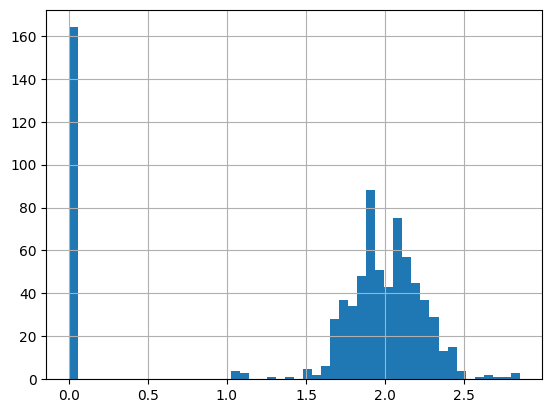

In [24]:
aggreate_relative_performances('tau+rank')['sum'].hist(bins=50)

Lastly if focusing only on weightedtau and percentile "KLD-PP:NS-1000-BINS" and "KLD-PP:NS-W:TS-100-BINS" stand out again. Closely followed by the 1000 bin variant "KLD-PP:NS-W:TS-1000-BINS". The clipped and inverted variant "KLD-C-I-PP:NS-100-BINS" was not presented in the paper. "KLD-PP:NS-100-BINS" is a 100 bins version of the "KLD-PP:NS-1000-BINS" task distance.

In [104]:
# Based on the above results we continued with the following three variations of bKLD
candidates = [
    'KLD-PP:NS-W:TS-100-BINS',  # small, target weighted
    'KLD-PP:NS-1000-BINS',  # large, unweighted
    'KLD-PP:NS-W:SN-1000-BINS'  # large, source weighted
]

### Reviewer request

During peer review additional similarity metrics have been requested based on the MMD concept we select the best hyperparameters from the development results.

In [20]:
df = aggreate_relative_performances('sum')
df[['MMD' in s for s in df.index]].head()
# -> MMD-geo-sinkhorn-0.01-10000-SAMPLES

,Model<br>Architecture,Pretraining<br>Data,Augmentation<br>Policy,Co-Training<br>Data,sum
MMD-geo-sinkhorn-0.01-10000-SAMPLES,3.244935,2.143428,1.852457,3.800899,11.041719
MMD-geo-sinkhorn-0.25-10000-SAMPLES,3.242689,2.143832,1.852894,3.799222,11.038637
MMD-geo-sinkhorn-0.2-10000-SAMPLES,3.240268,2.144930,1.852096,3.799682,11.036976
MMD-geo-sinkhorn-0.1-10000-SAMPLES,3.239746,2.142870,1.852063,3.797972,11.032651
MMD-geo-sinkhorn-0.15-10000-SAMPLES,3.239746,2.142870,1.852063,3.797972,11.032651
MMD-geo-sinkhorn-0.05-10000-SAMPLES,3.239746,2.142870,1.852063,3.797972,11.032651
MMD-geo-energy-0.3-10000-SAMPLES,3.053130,3.786276,2.423019,1.686910,10.949335
MMD-geo-energy-0.2-10000-SAMPLES,3.053130,3.786276,2.423019,1.686910,10.949335
MMD-geo-energy-0.1-10000-SAMPLES,3.053130,3.786276,2.423019,1.686910,10.949335
MMD-geo-energy-0.01-10000-SAMPLES,3.053130,3.786276,2.423019,1.686910,10.949335


### Alternative considerations

We also considered to use a ranking scheme instead of relativization as presented below, but went for the more granular relativization instead of the coarse ranking. We rank each evaluation within meta metric across and transfer scenarios and finally average rank these ranks.

In [70]:
s_list = []
for df, name in zip([aligned_regret_df, delta_df, weightedtau_df, gain_df, rank_df], ['regret', 'delta', 'tau', 'gain', 'rank']):
    for exp in EXPERIMENTS:
        s = df[exp + '-mean'].rank(ascending=False)
        s.name = exp[:5] + '-' + name
        s_list.append(s)
all_rankings = pd.DataFrame(s_list).T
all_rankings['mean'] = all_rankings.mean(axis=1)
all_rankings.sort_values(by='mean', ascending=True).head()

,Model-regret,Pretr-regret,Augme-regret,Co-Tr-regret,Model-delta,Pretr-delta,Augme-delta,Co-Tr-delta,Model-tau,Pretr-tau,...,Co-Tr-tau,Model-gain,Pretr-gain,Augme-gain,Co-Tr-gain,Model-rank,Pretr-rank,Augme-rank,Co-Tr-rank,mean
KLD-C-I-PP:NN-W:TS-100-BINS,26.0,221.0,149.0,269.0,31.0,17.0,233.0,212.0,17.0,45.0,...,241.0,51.5,174.5,48.0,288.5,9.0,72.0,69.0,276.0,136.375
KLD-PP:NS-W:SW-1000-BINS,3.5,506.5,115.5,64.5,196.5,481.5,245.5,8.5,175.5,184.5,...,56.5,2.0,115.5,10.5,32.5,28.5,278.5,200.5,14.5,138.025
KLD-PP:NS-W:SN-1000-BINS,3.5,506.5,115.5,64.5,196.5,481.5,245.5,8.5,175.5,184.5,...,56.5,2.0,115.5,10.5,32.5,28.5,278.5,200.5,14.5,138.025
JS-PP:NN-W:BS,160.5,63.5,218.5,89.5,90.5,21.5,313.5,129.5,335.0,160.0,...,31.0,128.0,174.5,10.5,157.5,87.0,44.5,195.5,112.5,144.600
L-1-NORM,32.0,407.0,49.0,112.0,21.0,61.0,47.0,215.0,118.0,125.0,...,137.0,32.5,560.5,48.0,201.5,131.0,399.0,29.0,140.0,147.875


As can be seen below, this approach does not cut off "really bad" task distances as precisely as the chosen approach does (high bar around 0 in above histograms). Note that lower is better in this case.

<AxesSubplot:>

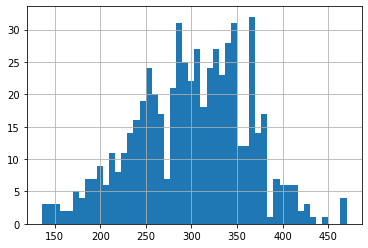

In [71]:
all_rankings['mean'].hist(bins=50)

We also considered ensembles of task distances, especially with respect to combining coarse and granular ones from the literature.

In [79]:
from mml_tf.distances import EnsembleDistances
from itertools import combinations
import pandas as pd

In [80]:
# the top performing candidates from option 1 above
top_candidates = aggreate_relative_performances('sum').iloc[:20].index.tolist()
# "large" fingerprint based task distances
fine_grained = [
    'FED', # fed
    'MMD-10000-SAMPLES', # mmd
    'VDNA-PP:NN-1000-BINS', # vdna
    'FID', # fid
]
# "small" fingerprint based task distances
superficial = [
    'EMD-AVG-PP:NN', # emd
    'KLD-PP:NN', # p2l
    'COS-PP:NN', # cosine 
    'L-1-NORM', # manhattan
    'L-2-NORM'  # euclidean
]

In [81]:
# load individual task distances
ensemble_variants = {name: LoadCachedDistances(name, zscore_axis=0) for name in top_candidates + fine_grained + superficial}

In [82]:
# build ensemble distances
ensembles = {}
for dist_a, dist_b in combinations(ensemble_variants.keys(), 2):
    # vary weighting of individual distances
        for frac in [0.2, 0.4, 0.6, 0.8]:
            name=f'{dist_a}_{dist_b}_{frac}'
            ensembles[name] = EnsembleDistances([ensemble_variants[dist_a], ensemble_variants[dist_b]], name=name, use_raws=False, weights=[frac, 1-frac])
ensemble_variants.update(ensembles)

In [83]:
len(ensemble_variants)

1431

In [84]:
# evaluate - same settings as above
ensemble_evals = get_evaluations(all_distances=[ensemble_variants[d] for d in ensemble_variants if d not in combined_variants], aggregates=[AggregateStrategy.MEAN], metrics=METRICS, experiments=EXPERIMENTS, top_meta_metrics=['regret', 'rank', 'delta', 'gain'], top_mode='avg', validation=False)

Calculating...: 100%|██████████| 258704/258704 [27:34<00:00, 156.39it/s]


In [85]:
# aggregate across target tasks - same as above
ens_regret = get_absolute_meta_values(full_evaluations=ensemble_evals, meta_metric='regret', reverse_regret=False)
ens_rank = get_absolute_meta_values(full_evaluations=ensemble_evals, meta_metric='rank')
ens_tau = get_absolute_meta_values(full_evaluations=ensemble_evals, meta_metric='weightedtau')
ens_gain = get_absolute_meta_values(full_evaluations=ensemble_evals, meta_metric='gain')
ens_delta = get_absolute_meta_values(full_evaluations=ensemble_evals, meta_metric='delta')

In [97]:
# compute relative performances WITHIN results from above - create and restore backups from dataframes above to not disrupt these results
backups = [aligned_regret_df.copy(), delta_df.copy(), weightedtau_df.copy(), gain_df.copy(), rank_df.copy()]
aligned_regret_df = pd.concat([aligned_regret_df, ens_regret])
delta_df = pd.concat([delta_df, ens_delta])
weightedtau_df = pd.concat([weightedtau_df, ens_tau])
gain_df = pd.concat([gain_df, ens_gain])
rank_df = pd.concat([rank_df, ens_rank])
exp_1 = get_relative_performance_by_experiment(EXPERIMENTS[0])
exp_2 = get_relative_performance_by_experiment(EXPERIMENTS[1])
exp_3 = get_relative_performance_by_experiment(EXPERIMENTS[2])
exp_4 = get_relative_performance_by_experiment(EXPERIMENTS[3])
aligned_regret_df, delta_df, weightedtau_df, gain_df, rank_df = backups
df = aggreate_relative_performances('sum')
df.sort_values(by='sum', ascending=False).head(n=20)

,Model<br>Architecture,Pretraining<br>Data,Augmentation<br>Policy,Co-Training<br>Data,sum
KLD-PP:NS-W:SW-1000-BINS_KLD-PP:NS-100-BINS_0.2,3.355496,2.592164,4.714286,4.019931,14.681877
KLD-PP:NS-W:SN-1000-BINS_KLD-PP:NS-100-BINS_0.2,3.355496,2.592164,4.714286,4.019931,14.681877
KLD-PP:NS-W:BN-1000-BINS_KLD-PP:NS-100-BINS_0.2,3.356967,2.597653,4.711771,4.005311,14.671702
KLD-PP:NS-100-BINS_JS-PP:NN-W:BS_0.8,3.766493,2.387947,4.269196,4.173907,14.597544
KLD-PP:NS-100-BINS_KLD-I-PP:NN_0.8,3.763644,2.391241,4.269809,4.143862,14.568556
KLD-PP:NS-100-BINS_JS-PP:NN_0.8,3.743335,2.368813,4.268639,4.148568,14.529354
KLD-PP:NS-100-BINS_KLD-C-I-PP:NN-W:SS-5-BINS_0.8,3.703084,2.360847,4.299021,4.140914,14.503866
KLD-PP:NS-100-BINS_KLD-PP:NN_0.8,3.742859,2.349825,4.271805,4.131338,14.495827
KLD-PP:NS-W:TS-1000-BINS_KLD-I-PP:NN_0.8,3.584054,2.751933,3.909963,3.779200,14.025150
KLD-PP:NS-1000-BINS_L-3-NORM-PP:SS-W:TN-5-BINS_0.8,3.453835,2.473749,3.895140,4.185052,14.007776


Apparently all the ensembled task distances rely on a bKLD variant with source weighted 1000 bins and unweighted 100 bins in the lead (weighting the latter one severely higher).

<AxesSubplot:>

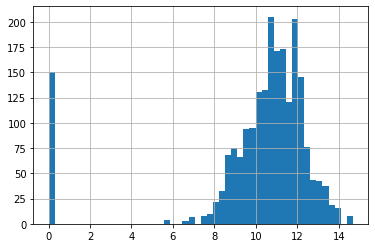

In [89]:
df['sum'].hist(bins=50)

We also inspected if there is a significant benefit if the weight is considered a scenario specific hyperparameter.

In [90]:
# find the best (most flexible ensemble)
base_ensembles = list(set([d[:-4].strip('_') for d in ensembles.keys()]))

In [100]:
rows = []
for base in base_ensembles:
    coarse = base.split('_')[0]
    fine = base.split('_')[1]
    inbetweens = [f'{base}_{frac}' for frac in [0.2, 0.4, 0.6, 0.8]]
    rel = df.loc[[coarse, fine] + inbetweens]
    exp_map = {}
    for exp in EXPERIMENTS:
        exp_map[exp] = rel[exp].max()
    row = {'base': base}
    row.update(exp_map)
    rows.append(row)
fancy = pd.DataFrame(rows)
fancy['sum'] = fancy[EXPERIMENTS].sum(axis=1)
fancy.sort_values('sum', ascending=False).head()

,base,Model<br>Architecture,Pretraining<br>Data,Augmentation<br>Policy,Co-Training<br>Data,sum
80,KLD-PP:NS-W:TS-100-BINS_KLD-PP:SS-W:TW-5-BINS,3.665895,4.539190,4.335822,4.162965,16.703872
281,KLD-PP:NS-W:TS-100-BINS_KLD-PP:SS-W:TN-5-BINS,3.665895,4.539190,4.335822,4.162965,16.703872
142,KLD-PP:NS-W:TS-100-BINS_L-3-NORM-PP:SS-W:TN-5-...,3.665895,4.474594,4.335822,4.162965,16.639276
113,KLD-PP:NS-W:SW-1000-BINS_KLD-PP:NS-100-BINS,3.925336,3.681568,4.714286,4.109126,16.430316
297,KLD-PP:NS-W:SN-1000-BINS_KLD-PP:NS-100-BINS,3.925336,3.681568,4.714286,4.109126,16.430316


In [101]:
b = fancy.sort_values('sum', ascending=False)['base'][0]   #'KLD-PP:NS-W:TS-100-BINS_KLD-PP:SS-W:TW-5-BINS'
x, y = b.split('_')
l = [y] + [b + f'_{frac}' for frac in [0.2, 0.4, 0.6, 0.8]] + [x]
df.loc[l]

,Model<br>Architecture,Pretraining<br>Data,Augmentation<br>Policy,Co-Training<br>Data,sum
KLD-C-I-PP:NN-W:SS-5-BINS,3.469068,3.769606,2.483632,2.223559,11.945864
KLD-C-I-PP:NS-100-BINS_KLD-C-I-PP:NN-W:SS-5-BINS_0.2,2.861409,2.875077,1.606518,3.082229,10.425232
KLD-C-I-PP:NS-100-BINS_KLD-C-I-PP:NN-W:SS-5-BINS_0.4,1.789295,3.051260,2.300241,3.377689,10.518485
KLD-C-I-PP:NS-100-BINS_KLD-C-I-PP:NN-W:SS-5-BINS_0.6,1.543884,2.518884,3.318491,2.477512,9.858770
KLD-C-I-PP:NS-100-BINS_KLD-C-I-PP:NN-W:SS-5-BINS_0.8,2.427492,1.891635,3.601215,2.957610,10.877953
KLD-C-I-PP:NS-100-BINS,2.983838,1.187913,4.203443,4.099076,12.474269


The above shows that the combination of "KLD-C-I-PP:NN-W:SS-5-BINS" and "KLD-C-I-PP:NS-100-BINS" only prefers the extreme cases of weights 0 and 1 - intermediate mixed task distances are inferior to either of these for all scenarios.